In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.0


In [4]:
sc.settings.set_figure_params(dpi=80, frameon=False)

In [5]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


In [6]:
sc.pp.recipe_zheng17(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.louvain(adata, resolution=1)
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']
adata=adata[~adata.obs["louvain_anno"].isin(["21", "23"])]

running recipe zheng17
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
    finished (0:00:00)
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989277  0.99671    0.9943037  0.9893978
     0.9883686  0.9873107  0.983987   0.983007   0.9790807  0.9762554
     0.9744368  0.9729162  0.96529746]
    finished (0:00:00)
computing neighbors
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    

# Figure 3a

running PAGA
    finished (0:00:00)


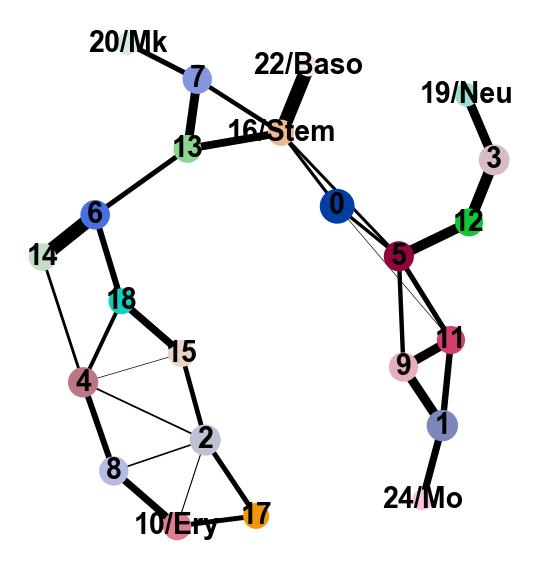

In [7]:
sc.tl.paga(adata, groups='louvain_anno')
sc.pl.paga(adata, threshold=0.03)

# Figure 3b

computing neighbors
    finished (0:00:01)
drawing single-cell graph using layout 'fa'
    finished (0:00:20)


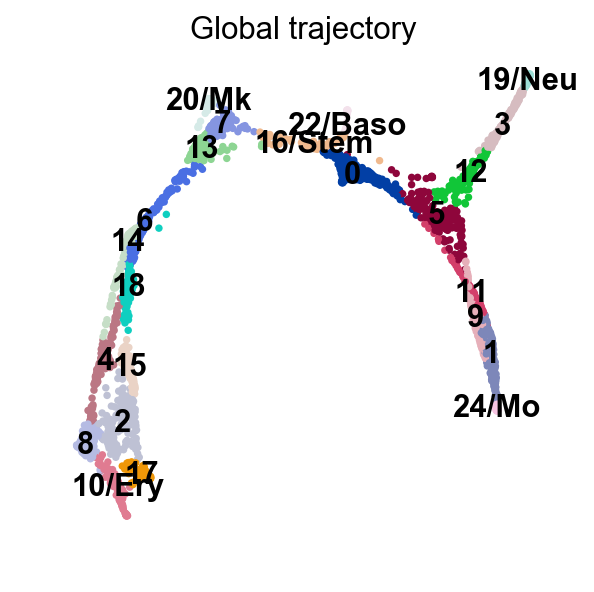

In [8]:
sc.pp.neighbors(adata, n_neighbors=100, use_rep='X_diffmap', n_pcs = 50)
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color = ["louvain_anno"], legend_loc = "on data",
                 save='Global trajectory.svg',title="Global trajectory")

# Figure 3c

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99679464 0.98921084 0.98066336 0.97836995 0.9736669
     0.96689427 0.95387864 0.9418143  0.93271136 0.91981316 0.90726393
     0.90223795 0.88958937 0.8761311 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


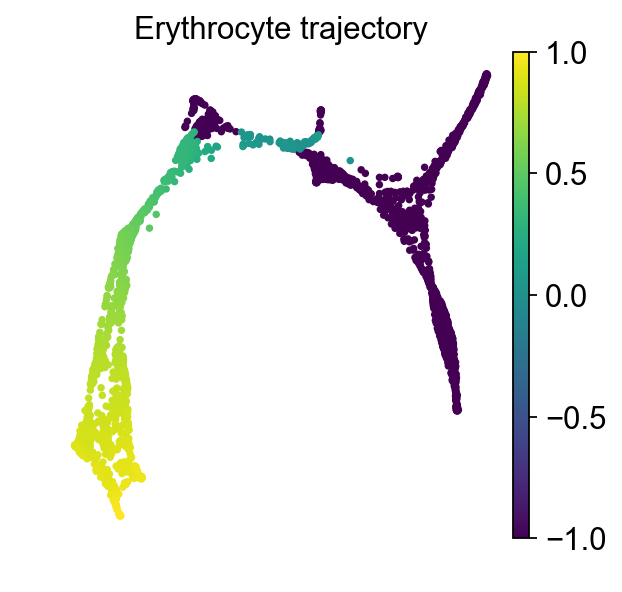

In [17]:
ok=adata.obs["louvain_anno"].isin(["16/Stem","13","6","14","18","4","15","2","8","10/Ery","17"])
subset_ery=adata[ok]
sc.tl.diffmap(subset_ery)
subset_ery.uns['iroot']=np.flatnonzero(subset_ery.obs['louvain_anno'] == '16/Stem')[0]
sc.tl.dpt(subset_ery)
adata.obs['Ery_dpt'] = -1
adata.obs.loc[subset_ery.obs_names,'Ery_dpt'] = subset_ery.obs["dpt_pseudotime"]
sc.pl.draw_graph(adata, color = ["Ery_dpt"], legend_loc = "on data",title="Erythrocyte trajectory")

# Figure 3d

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9953035  0.9816792  0.9657845  0.9603136  0.94055676
     0.9320042  0.9153228  0.90009713 0.88364345 0.8803218  0.86846566
     0.85770595 0.83751905 0.8236435 ]
    finished (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00)


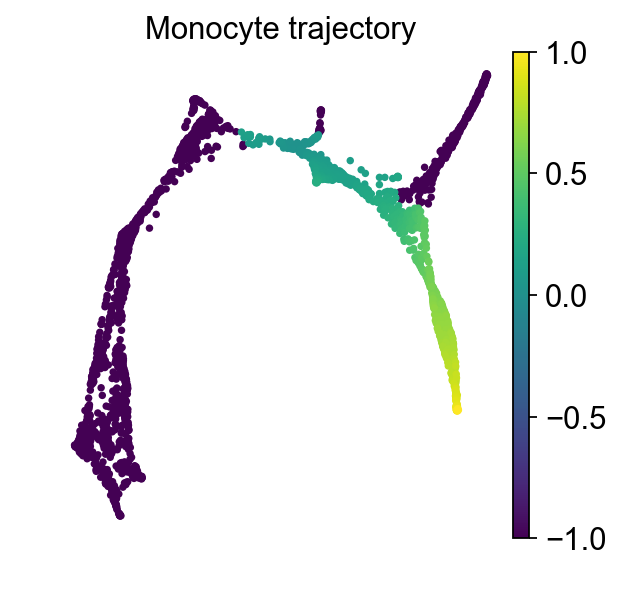

In [18]:
ok=adata.obs["louvain_anno"].isin(["16/Stem","0","5","11","9","1","24/Mo"])
subset_mono=adata[ok]
sc.tl.diffmap(subset_mono)
subset_mono.uns['iroot']=np.flatnonzero(subset_mono.obs['louvain_anno'] == '16/Stem')[0]
sc.tl.dpt(subset_mono)
adata.obs['Mono_dpt'] = -1
adata.obs.loc[subset_mono.obs_names,'Mono_dpt'] = subset_mono.obs["dpt_pseudotime"]
sc.pl.draw_graph(adata, color = ["Mono_dpt"], legend_loc = "on data",title="Monocyte trajectory")

# Figure 3e,f,g

In [24]:
import DrivAER as dv
C3_mouse = dv.get_anno(filename="C3.gmt",filetype="gmt",conv_mouse=True)

In [25]:
adata_raw = sc.datasets.paul15()
ery = adata_raw[subset_ery.obs_names,:]
ery = ery[:,subset_ery.var_names]

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


In [26]:
res1 = dv.calc_relevance(count = ery, pheno = subset_ery.obs['dpt_pseudotime'], 
                         tf_targets = C3_mouse[["GATAAGR_GATA_C","GATA_C", "GATA_Q6", "PU1_Q6"]], 
                         min_targets=5, datatype = "continuous")

1 / 4
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)



2019-11-20 20:48:48,327 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/api.py:149: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



dca: Successfully preprocessed 32 genes and 1254 cells.
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2019-11-20 20:48:48,516 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2019-11-20 20:48:48,911 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/train.py:41: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



2019-11-20 20:48:48,913 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/train.py:41: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



2019-11-20 20:48:49,103 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/loss.py:87: The name tf.lgamma is deprecated. Please use tf.math.lgamma instead.



2019-11-20 20:48:49,129 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/loss.py:88: The name tf.log is deprecated. Please use tf.math.log instead.



2019-11-20 20:48:49,181 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/loss.py:10: The name tf.is_nan is deprecated. Please use tf.math.is_nan instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-11-20 20:48:49,189 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/dca/loss.py:10: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-11-20 20:48:51,351 [WARNING] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



dca: Calculating low dimensional representations...
2 / 4
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
dca: Successfully preprocessed 22 genes and 1254 cells.
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
dca: Calculating low dimensional representations...
3 / 4
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
dca: Successfully preprocessed 19 genes and 1254 cells.
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
dca: Calculating low dimensional representations...
4 / 4
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts'

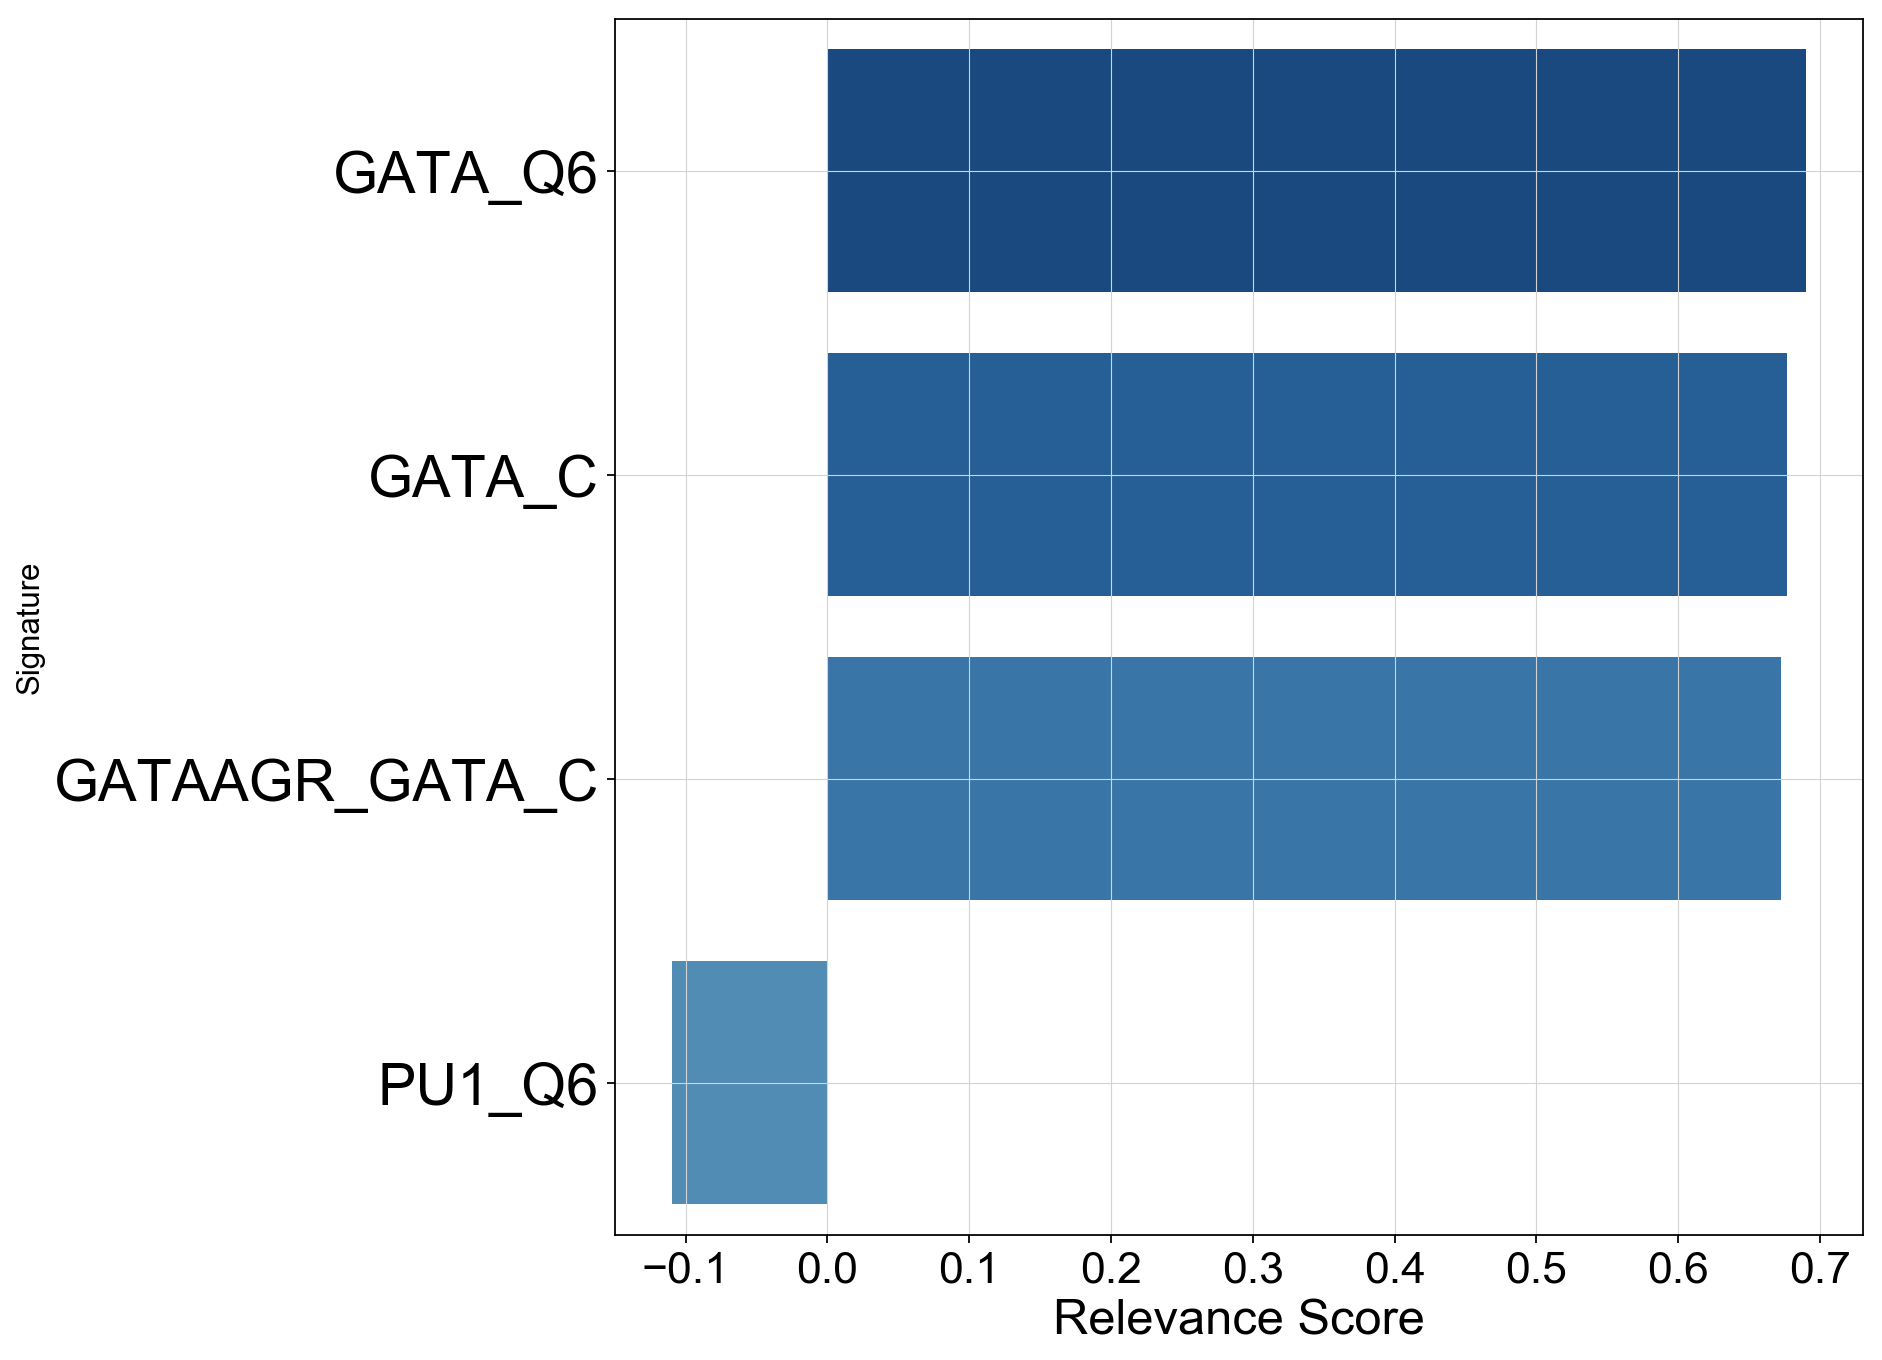

Top_TF : ['GATA_Q6', 'GATA_C', 'GATAAGR_GATA_C', 'PU1_Q6']
Worse_TF : ['GATA_Q6', 'GATA_C', 'GATAAGR_GATA_C', 'PU1_Q6']


In [27]:
dv.rank_plot(result=res1,save=False)

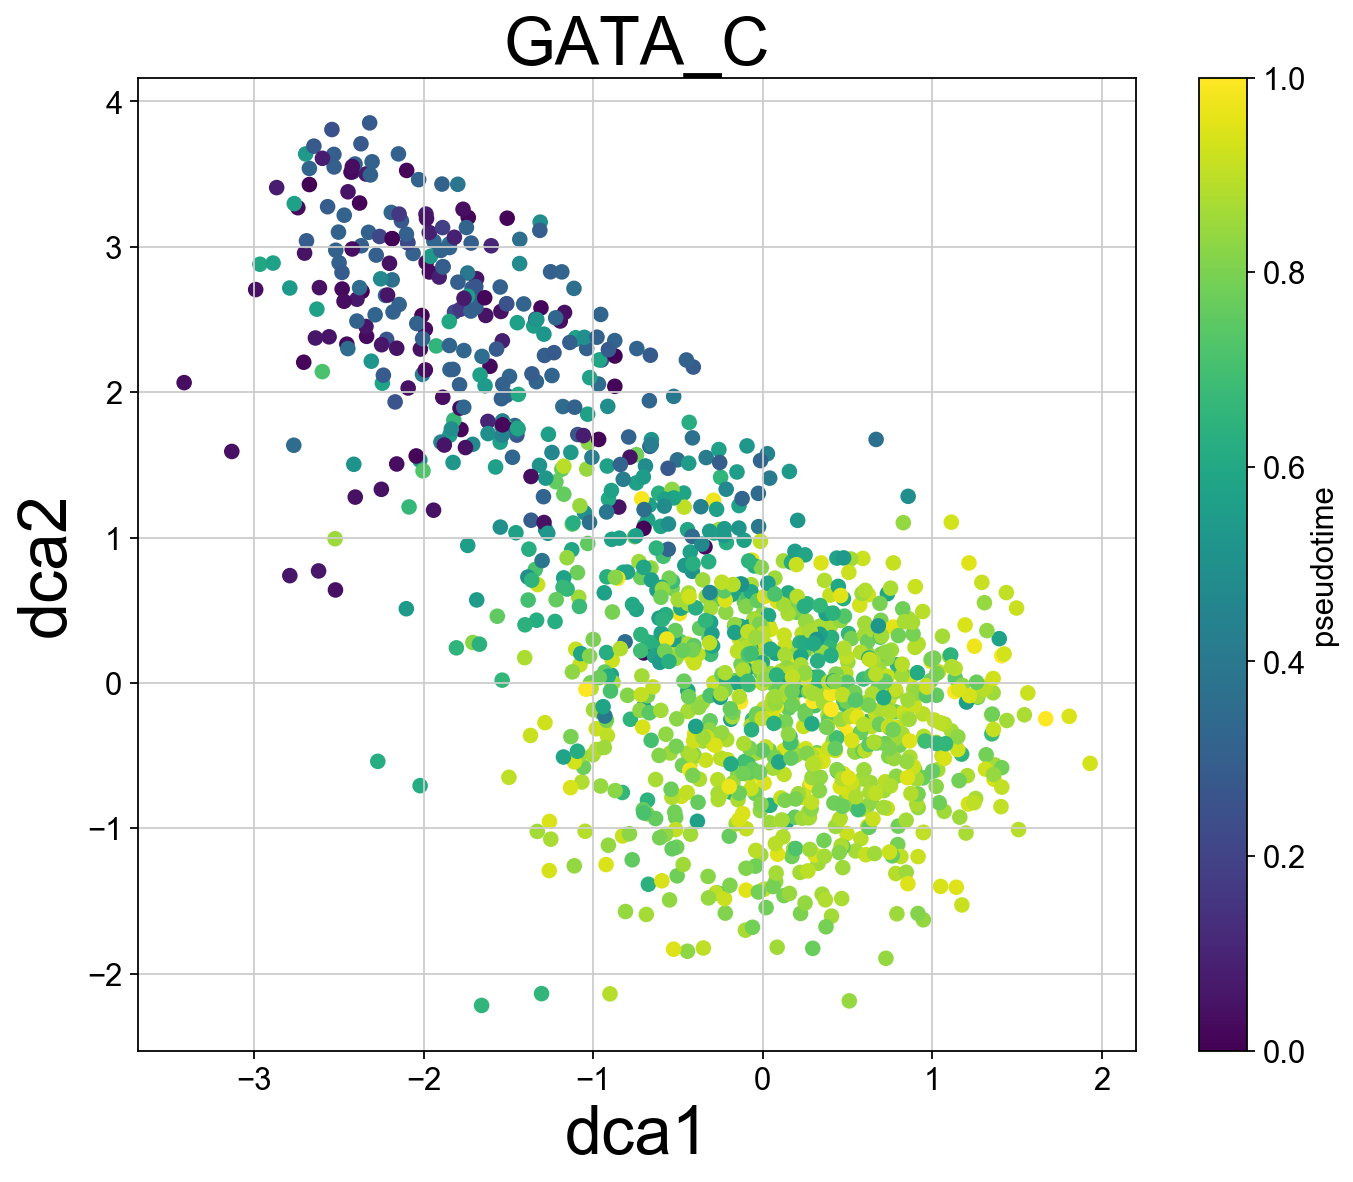

In [30]:
dv.embedding_plot(result=res1, tf_name="GATA_C", pheno=subset_ery.obs['dpt_pseudotime'], save=False)